## Data Loading : pre processing and patches

In [ ]:
import os
import pydicom
import numpy as np
from scipy.ndimage import zoom

# Code for resizing the images and saving them
def resize_slice(slice_array, new_shape):
    zoom_factors = [new_shape[0] / slice_array.shape[0], new_shape[1] / slice_array.shape[1]]
    resized_slice = zoom(slice_array, zoom_factors, order=1)  
    return resized_slice

def process_dicom_folder(input_dir, output_dir, new_shape):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    dicom_files = [f for f in os.listdir(input_dir)]
    for dicom_file in dicom_files:
        dicom_path = os.path.join(input_dir, dicom_file)
        dicom_data = pydicom.dcmread(dicom_path)
        
        slice_array = dicom_data.pixel_array
        original_shape = slice_array.shape
        print(f"Original shape of {dicom_file}: {original_shape}")
        
        resized_slice = resize_slice(slice_array, new_shape)
        
        dicom_data.PixelData = resized_slice.tobytes()
        dicom_data.Rows, dicom_data.Columns = new_shape[0], new_shape[1]
        
        output_path = os.path.join(output_dir, dicom_file)
        dicom_data.save_as(output_path)
        print(f"Saved resized slice to {output_path}")


input_dir = '../DatabaseWB/MR/400783198_MR_4'
output_dir = '../DatabaseWB_resizedImages/MR/400783198_MR_4'
new_shape = (240, 288)  
process_dicom_folder(input_dir, output_dir, new_shape)

In [111]:
import os
import torch 
import torchio as tio


# Function that will randomly split my data into 2 categories: training and testing 
# The validation set will be taken directly from the training set
def random_split(subjects, ratio=0.9):
    num_subjects = len(subjects)
    num_training_subjects = int(ratio * num_subjects)
    num_test_subjects = num_subjects - num_training_subjects

    num_split_subjects = num_training_subjects, num_test_subjects
    return torch.utils.data.random_split(subjects, num_split_subjects)

# Data loader: this function will load the images from the folders, create the datasets made of subjects and apply the correct
#               transforms such as normalisation, clamping, centering the origin
def DataLoader(folder):
    subjects_list = []
    ct_folder = os.path.join(base_folder, 'CT')
    mr_folder = os.path.join(base_folder, 'MR')
    
    ct_subfolders = [f for f in os.listdir(ct_folder) if os.path.isdir(os.path.join(ct_folder, f))]
    mr_subfolders = [f for f in os.listdir(mr_folder) if os.path.isdir(os.path.join(mr_folder, f))]
    
    # sort folders
    ct_subfolders.sort()
    mr_subfolders.sort()
    
    for ct_subfolder, mr_subfolder in zip(ct_subfolders, mr_subfolders):
        ct_patient_id = ct_subfolder.split('_')[0]
        mr_patient_id = mr_subfolder.split('_')[0]
    
        if ct_patient_id == mr_patient_id:
            ct_folder_path = os.path.join(ct_folder, ct_subfolder)
            mr_folder_path = os.path.join(mr_folder, mr_subfolder)

            sub = tio.Subject(
                CT = tio.ScalarImage(ct_folder_path),
                MR = tio.ScalarImage(mr_folder_path),
            ) 
            subjects_list.append(sub)
            
    transforms = [
        tio.ToCanonical(),
        tio.Clamp(out_min=-1000,out_max = 1000, include=(['CT'])),
        tio.RescaleIntensity(out_min_max=(0, 1), include=(['CT'])),
        tio.RescaleIntensity(out_min_max=(0, 1), include=(['MR'])),
    ]
    
    transfo = tio.Compose(transforms)
    
    train_val_subjects, testing_subjects = random_split(subjects_list, ratio=0.9)
    training_subjects, validation_subjects = random_split(train_val_subjects, ratio = 0.9)
    
    # Create the final datasets made from the different subjects
    training_dataset = tio.SubjectsDataset(training_subjects, transform=transfo)
    validation_dataset = tio.SubjectsDataset(validation_subjects, transform = transfo)
    testing_dataset = tio.SubjectsDataset(testing_subjects, transform = transfo)


    print('Datasets successfully created!')
    print('=======================================================')
    print(' Training set is made of', len(training_dataset), 'images \n Validation set is made of', len(validation_dataset), 'images \n', 'Testing set is made of', len(testing_dataset), 'images')
    print('=======================================================')
    
    return training_dataset, validation_dataset, testing_dataset
base_folder = '../DatabaseWB'
training_dataset, validation_dataset, testing_dataset = DataLoader(base_folder)

Datasets successfully created!
 Training set is made of 118 images 
 Validation set is made of 14 images 
 Testing set is made of 15 images


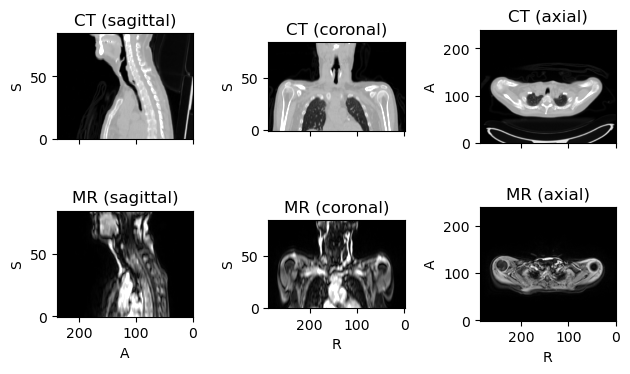

In [117]:
#for i in range(0,117): 
    #print(training_dataset[i].get('MR'))

training_dataset[14].plot()

In [118]:
# UNIFORM sampler
# Chose the sampler for your data
patch_size = (64,64,8)
sampler_uniform = tio.data.UniformSampler(patch_size)

In [119]:
from torch.utils.data import DataLoader
samples_per_volume=8
max_length=200 
num_workers=8


patches_training_set = tio.Queue(
        subjects_dataset=training_dataset,
        max_length=max_length, # Maximum number of patches that can be stored in the queue
        samples_per_volume=samples_per_volume, # Number if patches to be extracted from each volume
        sampler=sampler_uniform, # The sampler that we defined previously
        num_workers=num_workers, # Number of subprocesses to use for data loading
        shuffle_subjects=True,
        shuffle_patches=True,
    )

patches_validation_set = tio.Queue(
    subjects_dataset=validation_dataset,
    max_length=max_length,
    samples_per_volume=1,
    sampler=sampler_uniform,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

# Define loader, no need to shuffle it as the queue already does it
training_loader_patches = DataLoader(
    patches_training_set,
    batch_size = 16,
    num_workers = 0, # Need to set it to 0 for Loaders
    drop_last = True,
)

validation_loader_patches = DataLoader(
    patches_validation_set,
    batch_size = 16,
    num_workers = 0, # Need to set it to 0 for Loaders
    drop_last = True,
)

## Model definition and training

In [123]:
import os
import random
import time
from collections import OrderedDict
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torchio as tio
from torch.utils.tensorboard import SummaryWriter

import network_ResNet as network
from matplotlib import pyplot as plt
from util import print_log, format_train_log, format_validation_log


ModuleNotFoundError: No module named 'network_ResNet'

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

"""
Implementation based on original paper NeurIPS 2016
https://papers.nips.cc/paper/6096-learning-a-probabilistic-latent-space-of-object-shapes-via-3d-generative-adversarial-modeling.pdf
"""


class Discriminator(torch.nn.Module):
    def __init__(self, in_channels=1, dim=64, out_conv_channels=512):
        super(Discriminator, self).__init__()
        conv1_channels = int(out_conv_channels / 8)
        conv2_channels = int(out_conv_channels / 4)
        conv3_channels = int(out_conv_channels / 2)
        self.out_conv_channels = out_conv_channels
        self.out_dim = int(dim / 16)

        self.conv1 = nn.Sequential(
            nn.Conv3d(
                in_channels=in_channels, out_channels=conv1_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv1_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv2_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv3_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv3_channels, out_channels=out_conv_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(out_conv_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(out_conv_channels * self.out_dim * self.out_dim * self.out_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply linear + sigmoid
        x = x.view(-1, self.out_conv_channels * self.out_dim * self.out_dim * self.out_dim)
        x = self.out(x)
        return x


class Generator(torch.nn.Module):
    def __init__(self, in_channels=512, out_dim=64, out_channels=1, noise_dim=200, activation="sigmoid"):
        super(Generator, self).__init__()
        self.in_channels = in_channels
        self.out_dim = out_dim
        self.in_dim = int(out_dim / 16)
        conv1_out_channels = int(self.in_channels / 2.0)
        conv2_out_channels = int(conv1_out_channels / 2)
        conv3_out_channels = int(conv2_out_channels / 2)

        self.linear = torch.nn.Linear(noise_dim, in_channels * self.in_dim * self.in_dim * self.in_dim)

        self.conv1 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=in_channels, out_channels=conv1_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv1_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv2_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv2_out_channels, out_channels=conv3_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv3_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv3_out_channels, out_channels=out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            )
        )
        if activation == "sigmoid":
            self.out = torch.nn.Sigmoid()
        else:
            self.out = torch.nn.Tanh()

    def project(self, x):
        """
        projects and reshapes latent vector to starting volume
        :param x: latent vector
        :return: starting volume
        """
        return x.view(-1, self.in_channels, self.in_dim, self.in_dim, self.in_dim)

    def forward(self, x):
        x = self.linear(x)
        x = self.project(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return self.out(x)


def test_gan3d():
    noise_dim = 200
    in_channels = 512
    dim = 64  # cube volume
    model_generator = Generator(in_channels=512, out_dim=dim, out_channels=1, noise_dim=noise_dim)
    noise = torch.rand(1, noise_dim)
    generated_volume = model_generator(noise)
    print("Generator output shape", generated_volume.shape)
    model_discriminator = Discriminator(in_channels=1, dim=dim, out_conv_channels=in_channels)
    out = model_discriminator(generated_volume)
    print("Discriminator output", out)
    summary(model_generator, (1, noise_dim))
    summary(model_discriminator, (1, 64, 64, 64))


test_gan3d()

In [ ]:
import os
import random
import time
from collections import OrderedDict
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torchio as tio
from torch.utils.tensorboard import SummaryWriter

#import network as network
import network_ResNet as network
from matplotlib import pyplot as plt
from util import print_log, format_train_log, format_validation_log


class Model(object):
    def __init__(self, expr_dir, seed=None, batch_size=None,
                 epoch_count=1, niter=150, niter_decay=50, beta1=0.5, 
                 lr=0.0003, ngf=64, n_blocks=9, input_nc=1, output_nc=1, 
                 use_dropout=True, norm='batch', max_grad_norm=500.,
                 monitor_grad_norm=True, save_epoch_freq=10, print_freq=15, 
                 display_epoch_freq=1, testing=False, resume=False):

        self.expr_dir = expr_dir
        self.seed = seed
        self.device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
        self.batch_size = batch_size

        self.epoch_count = epoch_count
        self.niter = niter
        self.niter_decay = niter_decay
        self.beta1 = beta1
        self.lr = lr
        self.old_lr = self.lr

        self.ngf = ngf
        self.n_blocks = n_blocks
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.use_dropout = use_dropout
        self.norm = norm
        self.max_grad_norm = max_grad_norm

        self.monitor_grad_norm = monitor_grad_norm
        self.save_epoch_freq = save_epoch_freq
        self.print_freq = print_freq
        self.display_epoch_freq = display_epoch_freq
        self.time = datetime.now().strftime("%Y%m%d-%H%M%S")

        # define network we need here
        self.netG = network.define_generator(input_nc=self.input_nc, 
                                             output_nc=self.output_nc, 
                                             ngf=self.ngf,
                                             n_blocks=self.n_blocks, 
                                             use_dropout=self.use_dropout,
                                             device=self.device)

        # define all optimizers here
        self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                            lr=self.lr, 
                                            betas=(self.beta1, 0.999),
                                            )

        self.loss = nn.MSELoss()

        self.resume = resume

        if not os.path.exists(expr_dir):
            os.makedirs(expr_dir)

        if not os.path.exists(os.path.join(expr_dir, 'TensorBoard')):
            os.makedirs(os.path.join(expr_dir, 'TensorBoard', self.time))

        if not os.path.exists(os.path.join(expr_dir, 'TensorBoard', self.time, 'training_visuals')):
            os.makedirs(os.path.join(expr_dir, 'TensorBoard', self.time, 'training_visuals'))

        if not os.path.exists(os.path.join(expr_dir, 'TensorBoard', self.time, 'testing_visuals')):
            os.makedirs(os.path.join(expr_dir, 'TensorBoard', self.time, 'testing_visuals'))

        if not testing:
            num_params = 0
            with open("%s/nets.txt" % self.expr_dir, 'w') as nets_f:
                num_params += network.print_network(self.netG, nets_f)
                nets_f.write('# parameters: %d\n' % num_params)
                nets_f.flush()

        if resume:
            self.load(os.path.join(self.expr_dir, "latest"), True)
            self.netG.to(self.device)

    def train(self, train_dataset, validation_set):
        self.batch_size = train_dataset.batch_size
        self.save_options()
        out_f = open(f"{self.expr_dir}/results.txt", 'w')
        use_gpu = torch.cuda.is_available()

        tensorboard_writer = SummaryWriter(os.path.join(self.expr_dir, 'TensorBoard', self.time))

        if self.seed is not None:
            print(f"using random seed: {self.seed}")
            random.seed(self.seed)
            np.random.seed(self.seed)
            torch.manual_seed(self.seed)
            if use_gpu:
                torch.cuda.manual_seed_all(self.seed)

        total_steps = 0
        print_start_time = time.time()

        for epoch in range(self.epoch_count, self.niter + self.niter_decay + 1):
            epoch_start_time = time.time()
            epoch_iter = 0
            total_loss = 0
            for data in train_dataset:
                b0_guidance = data['b0guidance'][tio.DATA].to(self.device)
                b0_guidance = b0_guidance.transpose_(2, 4)
                b0_guidance = torch.squeeze(b0_guidance, dim=2)
                b800_noisy = data['b800noisy'][tio.DATA].to(self.device)
                b800_noisy = b800_noisy.transpose_(2, 4)
                b800_noisy = torch.squeeze(b800_noisy, dim=2)
                b800_reference = data['b800reference'][tio.DATA].to(self.device)
                b800_reference = b800_reference.transpose_(2, 4)
                b800_reference = torch.squeeze(b800_reference, dim=2)
                total_steps += self.batch_size
                epoch_iter += self.batch_size
                
                if self.monitor_grad_norm:
                    losses, visuals, _ = self.train_instance(b0_guidance, b800_noisy, b800_reference)
                else:
                    losses, visuals = self.train_instance(b0_guidance, b800_noisy, b800_reference)
                
                total_loss += losses['Loss']
                    
            loss = total_loss/len(train_dataset)
                
            if total_steps % self.print_freq == 0:
                t = (time.time() - print_start_time) / self.batch_size
                print_log(out_f, format_train_log(epoch, epoch_iter, losses, t))
                tensorboard_writer.add_scalars('Loss', {'train': loss}, total_steps)
                print_start_time = time.time()

            print_start_time = time.time()
            
            if epoch % self.display_epoch_freq == 0:
                self.visualize(visuals, data['b0guidance'][tio.AFFINE], epoch, 
                               epoch_iter / self.batch_size)

            if epoch % self.save_epoch_freq == 0:
                print_log(out_f, 'saving the model at the end of epoch %d, iterations %d' % (epoch, total_steps))
                self.save('latest')

                losses_validation, visuals_validation, affine = self.validation(validation_set)

                self.visualize(visuals_validation, affine, epoch, epoch_iter / self.batch_size, "testing")
                t = (time.time() - print_start_time) / self.batch_size
                print_log(out_f, format_validation_log(epoch, epoch_iter, losses_validation, t))

                tensorboard_writer.add_scalars('Loss', {'Test': losses_validation['Loss']},
                                               total_steps)
            print_log(out_f, 'End of epoch %d / %d \t Time Taken: %d sec' %
                      (epoch, self.niter + self.niter_decay, time.time() - epoch_start_time))

            if epoch > self.niter:
                self.update_learning_rate()

        out_f.close()
        tensorboard_writer.close()


    def train_instance(self, b0_guidance, b800_noisy, b800_reference):
        
        inpt = torch.cat((b800_noisy, b0_guidance), dim=1)
        b800_denoised = self.netG.forward(inpt)

        self.optimizer_G.zero_grad()
        loss = self.loss(b800_denoised, b800_reference)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(self.netG.parameters(), 
                                                   self.max_grad_norm)
        self.optimizer_G.step()

        losses = OrderedDict([('Loss', loss.data.item())])
        visuals = OrderedDict([('Noisy_b800', b800_noisy.data),
                               ('Denoisy_b800', b800_denoised.data),
                               ('Reference_b800', b800_reference.data)
                               ])
        if self.monitor_grad_norm:
            grad_norm = OrderedDict([('grad_norm', grad_norm)])

            return losses, visuals, grad_norm

        return losses, visuals
    
    
    
    def validation(self, validation_set):
        
        self.netG.eval()
        
        total_loss = 0
        with torch.no_grad():
            for data in validation_set:
                
                b0_guidance = data['b0guidance'][tio.DATA].to(self.device)
                b0_guidance = b0_guidance.transpose_(2, 4)
                b0_guidance = torch.squeeze(b0_guidance, dim=2)
                b800_noisy = data['b800noisy'][tio.DATA].to(self.device)
                b800_noisy = b800_noisy.transpose_(2, 4)
                b800_noisy = torch.squeeze(b800_noisy, dim=2)
                b800_reference = data['b800reference'][tio.DATA].to(self.device)
                b800_reference = b800_reference.transpose_(2, 4)
                b800_reference = torch.squeeze(b800_reference, dim=2)
                
                inpt = torch.cat((b800_noisy, b0_guidance), dim=1)
                b800_denoised = self.netG.forward(inpt)
                
                loss_val = self.loss(b800_denoised, b800_reference)
                total_loss += loss_val.item()

        total_loss = total_loss / len(validation_set)
        
        losses = OrderedDict([('Loss', total_loss)])
        visuals = OrderedDict([('Noisy_b800', b800_noisy.data),
                               ('Denoisy_b800', b800_denoised.data),
                               ('Reference_b800', b800_reference.data),
                               ])
        
        return losses, visuals, data['b0guidance'][tio.AFFINE]



    def update_learning_rate(self):
        lrd = self.lr / self.niter_decay
        lr = self.old_lr - lrd
        for param_group in self.optimizer_G.param_groups:
            param_group['lr'] = lr

        print('update learning rate: %f -> %f' % (self.old_lr, lr))
        self.old_lr = lr



    def save(self, checkpoint_name):
        checkpoint_path = os.path.join(self.expr_dir, checkpoint_name)
        checkpoint = {
            'netG': self.netG.state_dict(),
            'optimizer_G': self.optimizer_G.state_dict()
        }
        torch.save(checkpoint, checkpoint_path)
        
        
        
    def visualize(self, visuals, affine, epoch, index, state="training"):
        b800_noisy = visuals['Noisy_b800'].cpu().transpose_(1, 3)
        b800_denoised = visuals['Denoisy_b800'].cpu().transpose_(1, 3)
        b800_reference = visuals['Reference_b800'].cpu().transpose_(1, 3)
        
        b800_noisy = b800_noisy[:,None,:,:,:]
        b800_denoised = b800_denoised[:,None,:,:,:]
        b800_reference = b800_reference[:,None,:,:,:]
        
        for i in range(1):
            subject = tio.Subject(
                Noisy=tio.ScalarImage(tensor=b800_noisy[i], affine=affine[i]),
                Denoisy=tio.ScalarImage(tensor=b800_denoised[i], affine=affine[i]),
                Reference=tio.ScalarImage(tensor=b800_reference[i], affine=affine[i]),
            )

            save_path = os.path.join(self.expr_dir, 'TensorBoard', self.time, state + "_visuals")
            save_path = os.path.join(save_path, 'cycle_' + str(epoch) + '_' + str(index) + '_' + str(
                i) + '.png')
            subject.plot(show=False, output_path=save_path)
        plt.close('all')



    def load(self, checkpoint_path, optimizer=False):
        checkpoint = torch.load(checkpoint_path)
        #checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        self.netG.load_state_dict(checkpoint['netG'])

        if optimizer:
            self.optimizer_G.load_state_dict(checkpoint['optimizer_G'])



    def eval(self):
        self.netG.eval()
        
        
    def inferencePatch(self, dataset, export_path=None, checkpoint=None, save=False):
        
        checkpoint = checkpoint or os.path.join(self.expr_dir, "latest")
        
        self.load(checkpoint)
        self.eval()

        subjects = []
        for n,subject in enumerate(dataset.subject):
            
            grid_sampler = tio.inference.GridSampler(
                subject,
                dataset.patch_size,
                dataset.patch_overlap)
            
            aggregator = tio.inference.GridAggregator(grid_sampler, 
                                                      overlap_mode='hann')
            loader = torch.utils.data.DataLoader(
                grid_sampler, batch_size=1, drop_last=True)
            
            start = time.time()
            with torch.no_grad():
                for i, data in enumerate(loader):
                    
                    b0_guidance = data['b0guidance'][tio.DATA].to(self.device)
                    b0_guidance = b0_guidance.transpose_(2, 4)
                    b0_guidance = torch.squeeze(b0_guidance, dim=2)
                    locations = data[tio.LOCATION]
                    b800_noisy = data['b800noisy'][tio.DATA].to(self.device)
                    b800_noisy = b800_noisy.transpose_(2, 4)
                    b800_noisy = torch.squeeze(b800_noisy, dim=2)
                    
                    inpt = torch.cat((b800_noisy, b0_guidance), dim=1)
                    b800_denoised = self.netG.forward(inpt)
                    
                    b800_denoised = b800_denoised[:,:,None,:,:]
                    b800_denoised = b800_denoised.transpose_(2, 4)
                                    
                    aggregator.add_batch(b800_denoised, locations)
                    
                    print(f"patch {i + 1}/{len(loader)}")
                    
                foreground = aggregator.get_output_tensor()
                affine = torch.squeeze(data['b0guidance'][tio.AFFINE],dim=0)
                b0_guidance = data['b0guidance'][tio.DATA].to(self.device)
                                
                subject = tio.Subject(
                    b800denoisy = tio.ScalarImage(tensor=foreground, affine=affine)
                    )
                    
                print(f"{time.time() - start} sec. for evaluation")
                subjects.append(subject)
            
        return subjects
    